In [122]:
import pandas as pd
import numpy as np

data = pd.DataFrame(pd.read_csv("heart_2022_no_nans.csv"))

### Підготовка даних до початку порівняння методів балансування

In [123]:
data = data.drop(columns=["State", "RaceEthnicityCategory"])
data = data.replace("Female", "0")
data = data.replace("Male", "1")
data["AgeCategory"] = data["AgeCategory"].str[4:6]

data["GeneralHealth"] = data["GeneralHealth"].replace({"Poor":"0", "Fair":"1", "Good":"2", "Very good":"3", "Excellent":"4"})
data["LastCheckupTime"] = data["LastCheckupTime"].replace({"Within past year (anytime less than 12 months ago)":"0",
                                                           "Within past 2 years (1 year but less than 2 years ago)": "1",
                                                          "Within past 5 years (2 years but less than 5 years ago)": "2",
                                                          "5 or more years ago": "3"})

data["RemovedTeeth"] = data["RemovedTeeth"].replace({"All": "3", 
                                                     "6 or more, but not all": "2",
                                                     "1 to 5": "1",
                                                     "None of them": "0"
                                                    })


data["HadDiabetes"] = data["HadDiabetes"].replace({"No":"0",
                                                  "No, pre-diabetes or borderline diabetes": "1",
                                                  "Yes, but only during pregnancy (female)": "2",
                                                  "Yes": "3"})

data["SmokerStatus"] = data["SmokerStatus"].replace({"Never smoked": "0",
                                                    "Former smoker": "1",
                                                    "Current smoker - now smokes some days": "2",
                                                    "Current smoker - now smokes every day": "3"})

data["ECigaretteUsage"] = data["ECigaretteUsage"].replace({"Never used e-cigarettes in my entire life": "0",
                                                          "Not at all (right now)": "1",
                                                          "Use them some days": "2",
                                                          "Use them every day":"3"})

data["TetanusLast10Tdap"] = data["TetanusLast10Tdap"].replace({"No, did not receive any tetanus shot in the past 10 years": "0",
                                                              "Yes, received tetanus shot but not sure what type": "1",
                                                              "Yes, received tetanus shot, but not Tdap": "2",
                                                              "Yes, received Tdap": "3"})
data["CovidPos"] = data["CovidPos"].replace({"No":"0", 
                                             "Tested positive using home test without a health professional": "1",
                                             "Yes": "2"})

data = data.replace({"No":"0",
                     "Yes": "1"})

data.head()

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,0,3,4.0,0.0,0,1,9.0,0,0,0,...,1.60,71.67,27.99,0,0,1,1,3,0,0
1,1,3,0.0,0.0,0,1,6.0,0,0,0,...,1.78,95.25,30.13,0,0,1,1,1,0,0
2,1,3,0.0,0.0,0,0,8.0,2,0,0,...,1.85,108.86,31.66,1,0,0,1,0,0,2
3,0,1,5.0,0.0,0,1,9.0,0,0,0,...,1.70,90.72,31.32,0,0,1,1,0,0,2
4,0,2,3.0,15.0,0,1,5.0,1,0,0,...,1.55,79.38,33.07,0,0,1,1,0,0,0


In [124]:
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

le = LabelEncoder()
data1 = data.copy(deep=True)


col = list(data.columns)
categorical_features = []
numerical_features = []
for i in data1.columns:
    if len(data[i].unique()) > 6:
        numerical_features.append(i)
    else:
        data1[i] = le.fit_transform(data1[i])
        categorical_features.append(i)

In [125]:
X = data1.drop(['HadHeartAttack'], axis=1)
y = data1['HadHeartAttack']
X_initial_train, X_initial_test, y_initial_train, y_initial_test = train_test_split(X, y, test_size=0.35, random_state=0)
scaler = StandardScaler()

Одразу розділяємо дані на набори для тренування та тестування. Балансування класів на всій множині даних призводить до витоку даних та перенавчанню моделі (особливо дерева рішень), також це завадить корректні оцінці моделі на початкових даних. Балансування класів буде відбуватись на тренувальному наборі, тестування моделей - на наборі для тестування.

### Функція валідації моделі

Модель випробовується на початкових даних. Працює як для моделі логістичної регресії, так і для моделі дерева рішень.

In [126]:
all_logreg_logs = pd.DataFrame()
all_dtree_logs = pd.DataFrame()

def validate_model(model, model_scaler, balancing_method_name: str):        
    global all_logreg_logs, all_dtree_logs, X_initial_test, y_initial_test
    
    X_initial_scaled = model_scaler.transform(X_initial_test)
    
    if isinstance(model, LogisticRegression):
        weights = model.coef_[0]
        intercept = model.intercept_[0]
        
        logits = np.dot(X_initial_scaled, weights) + intercept
        probabilities = 1 / (1 + np.exp(-logits))
        y_pred_initial = (probabilities >= 0.5).astype(int)
    else:
        probabilities = model.predict_proba(X_initial_scaled)[:, 1]
        y_pred_initial = model.predict(X_initial_scaled)
    
    accuracy_initial = accuracy_score(y_initial_test, y_pred_initial)
    precision_initial = precision_score(y_initial_test, y_pred_initial)
    recall_initial = recall_score(y_initial_test, y_pred_initial)
    f1_initial = f1_score(y_initial_test, y_pred_initial)
    roc_auc_initial = roc_auc_score(y_initial_test, probabilities)
    initial_validation_log = pd.DataFrame(data=[accuracy_initial,
                                                precision_initial,
                                                recall_initial,
                                                f1_initial,
                                                roc_auc_initial],
                                          index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'],
                                          columns=[f"{balancing_method_name}"])
    
    if isinstance(model, LogisticRegression):
        all_logreg_logs = pd.concat([all_logreg_logs, initial_validation_log], axis=1)
        print("\nLogistic Regression")
        print(all_logreg_logs.transpose())
    else:
        all_dtree_logs = pd.concat([all_dtree_logs, initial_validation_log], axis=1)
        print("\nDecision Tree")
        print(all_dtree_logs.transpose())

### Функції тренування моделей

Відбувається почергове тренування спочатку моделі логістичної регресії, а після й моделі дерева рішень. Після тренування кожної моделі виводиться лог точності моделі по **збалансованим даним**. Після ввідбувається валідація кожної моделі та заноситься у загальний лог по всім методам та моделям.

In [127]:
def train_models(X_balanced, y_balanced, balancing_method_name: str):
    global scaler
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.35, random_state=0)
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
        
    logreg_model = train_regression_model(X_train_scaled, X_test_scaled, y_train, y_test)
    
    dtree_model = train_dtree_model(X_train_scaled, X_test_scaled, y_train, y_test)

    print("\n\nComparison After Validation")
    validate_model(logreg_model, scaler, balancing_method_name)
    validate_model(dtree_model, scaler, balancing_method_name)

In [128]:
def train_regression_model(X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced):
    logreg = LogisticRegression(solver="liblinear", penalty="l2", C=0.00001, max_iter=10000)
    logreg.fit(X_train_balanced, y_train_balanced)
    y_pred_log = logreg.predict(X_test_balanced)
    
    y_pred_proba_log = logreg.predict_proba(X_test_balanced)
    fpr_log, tpr_log, _ = metrics.roc_curve(y_test_balanced, y_pred_proba_log[:,1])
    
    log = pd.DataFrame(data=[accuracy_score(y_test_balanced, y_pred_log),
                             precision_score(y_test_balanced, y_pred_log, average='binary'),
                             recall_score(y_test_balanced, y_pred_log, average='binary'),
                             f1_score(y_test_balanced, y_pred_log, average='binary'),
                             roc_auc_score(y_test_balanced, y_pred_proba_log[:,1])],
                       index=['Accuracy','Precision','Recall','F1-score','AUC'],
                       columns=["Logistic Regression"])
    print(log)
    return logreg

In [129]:
def train_dtree_model(X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced):
    dtree = DecisionTreeClassifier(random_state=0)
    dtree.fit(X_train_balanced, y_train_balanced)
    y_pred_tree = dtree.predict(X_test_balanced)
    
    y_pred_proba_tree = dtree.predict_proba(X_test_balanced)
    fpr_tree, tpr_tree, _ = metrics.roc_curve(y_test_balanced, y_pred_proba_tree[:, 1])
    
    log = pd.DataFrame(data=[accuracy_score(y_test_balanced, y_pred_tree),
                             precision_score(y_test_balanced, y_pred_tree, average='binary'),
                             recall_score(y_test_balanced, y_pred_tree, average='binary'),
                             f1_score(y_test_balanced, y_pred_tree, average='binary'),
                             roc_auc_score(y_test_balanced, y_pred_proba_tree[:, 1])],
                       index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'],
                       columns=["Decision Tree"])
    print(log)
    return dtree

In [ ]:
# Показуємо розподіл після методу балансування
def show_stats(y_balanced, balanced_method_name):
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x=y_balanced, hue=y_balanced, palette="Set2")
    for container in ax.containers:
        ax.bar_label(container, label_type='center', rotation=0, color='white')
    plt.title(f"Розподіл після {balanced_method_name}", size=16)
    plt.show()

### Without sampling

Перевірка точності моделі без балансування класів. Так ми зможемо зрозуміти якщо модель після балансування класів буде менш точною.

In [130]:
train_models(X_initial_train, y_initial_train, "Without_Sampling")

           Logistic Regression
Accuracy              0.941487
Precision             0.460132
Recall                0.385342
F1-score              0.419429
AUC                   0.880946
           Decision Tree
Accuracy        0.911756
Precision       0.246542
Recall          0.296091
F1-score        0.269054
AUC             0.621789


Comparison After Validation

Logistic Regression
                  Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling  0.942793   0.470887  0.394294    0.4292  0.885052

Decision Tree
                  Accuracy  Precision   Recall  F1-score       AUC
Without_Sampling  0.913121   0.248464  0.29274  0.268791  0.620827


## Undersampling

Усього було випробовано 9 методів: Random Undersampling, Tomek Links, Edited Nearest Neighbours, One Sided Selection, Neighbourhood Cleaning Rule, AllKNN, NearMiss, Cluster Centroids та Instance Hardness Threshold.

### Random Undersampling

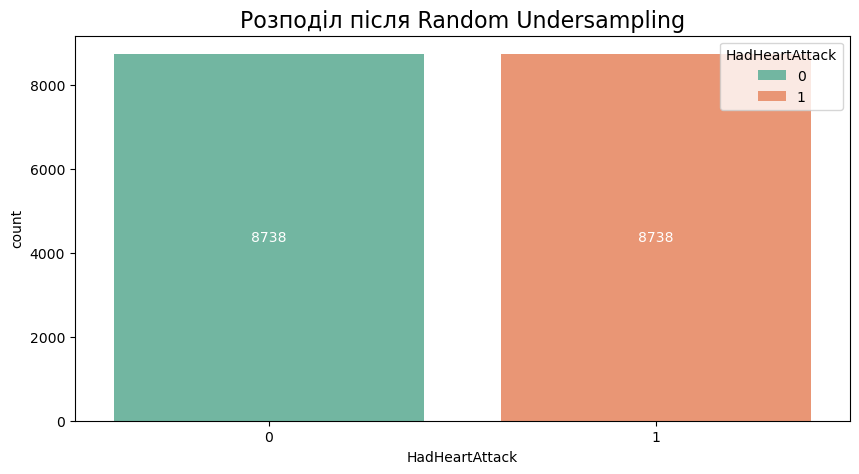

In [131]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

undersample = RandomUnderSampler(sampling_strategy='majority')
X_RUS, y_RUS = undersample.fit_resample(X_initial_train, y_initial_train)

show_stats(y_RUS, "RandomUndersampling")

In [132]:
train_models(X_RUS, y_RUS, "Random Undersampling")

           Logistic Regression
Accuracy              0.775217
Precision             0.790730
Recall                0.748037
F1-score              0.768791
AUC                   0.856058
           Decision Tree
Accuracy        0.728298
Precision       0.727036
Recall          0.730366
F1-score        0.728697
AUC             0.728300


Comparison After Validation

Logistic Regression
                      Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling      0.942793   0.470887  0.394294  0.429200  0.885052
Random_Undersampling  0.794409   0.175855  0.751118  0.284987  0.855964

Decision Tree
                      Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling      0.913121   0.248464  0.292740  0.268791  0.620827
Random_Undersampling  0.721141   0.131435  0.733234  0.222913  0.726839


### Tomek Links

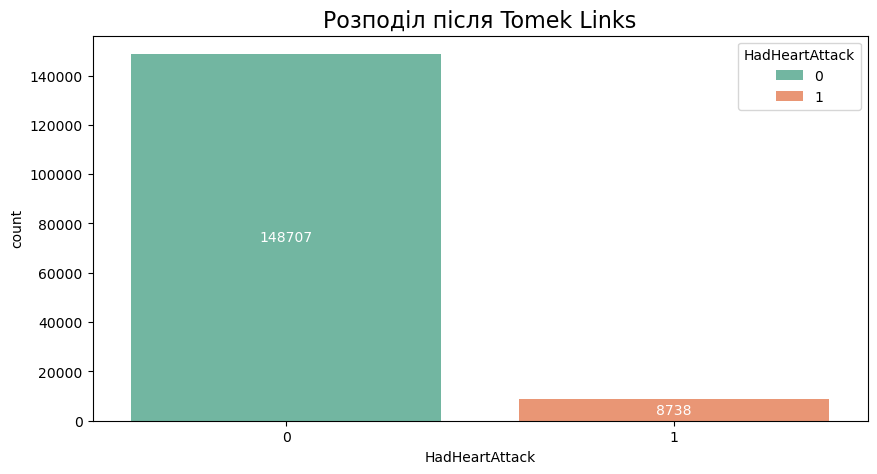

In [133]:
from imblearn.under_sampling import TomekLinks

tomek = TomekLinks()
X_TL, y_TL = tomek.fit_resample(X_initial_train, y_initial_train)

show_stats(y_TL, "Tomek Links")

In [134]:
train_models(X_TL, y_TL, "Tomek_Links")

           Logistic Regression
Accuracy              0.940115
Precision             0.442182
Recall                0.407780
F1-score              0.424285
AUC                   0.880373
           Decision Tree
Accuracy        0.914311
Precision       0.254930
Recall          0.303488
F1-score        0.277097
AUC             0.626372


Comparison After Validation

Logistic Regression
                      Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling      0.942793   0.470887  0.394294  0.429200  0.885052
Random_Undersampling  0.794409   0.175855  0.751118  0.284987  0.855964
Tomek_Links           0.940342   0.450849  0.429636  0.439987  0.884401

Decision Tree
                      Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling      0.913121   0.248464  0.292740  0.268791  0.620827
Random_Undersampling  0.721141   0.131435  0.733234  0.222913  0.726839
Tomek_Links           0.912006   0.254685  0.318288  0.282956  0.632274


### Edited Nearest Neighbours

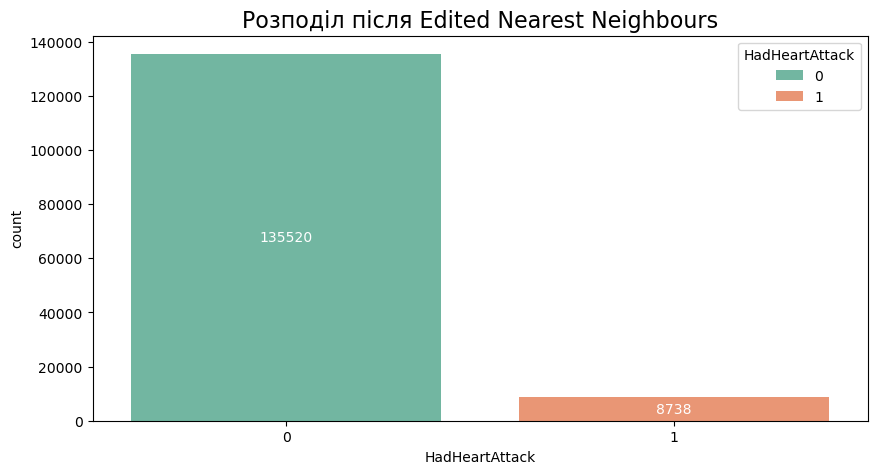

In [135]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours()
X_ENN, y_ENN = enn.fit_resample(X_initial_train, y_initial_train)

show_stats(y_ENN, "Edited Nearest Neighbours")

In [136]:
train_models(X_ENN, y_ENN, "Edited_Nearest_Neighbours")

           Logistic Regression
Accuracy              0.936028
Precision             0.477293
Recall                0.529756
F1-score              0.502158
AUC                   0.898347
           Decision Tree
Accuracy        0.915827
Precision       0.328066
Recall          0.364553
F1-score        0.345348
AUC             0.658065


Comparison After Validation

Logistic Regression
                           Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling           0.942793   0.470887  0.394294  0.429200  0.885052
Random_Undersampling       0.794409   0.175855  0.751118  0.284987  0.855964
Tomek_Links                0.940342   0.450849  0.429636  0.439987  0.884401
Edited_Nearest_Neighbours  0.924467   0.368582  0.539493  0.437954  0.882395

Decision Tree
                           Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling           0.913121   0.248464  0.292740  0.268791  0.620827
Random_Undersampling       0.721141   0.131435  0.733234  0

### One Sided Selection

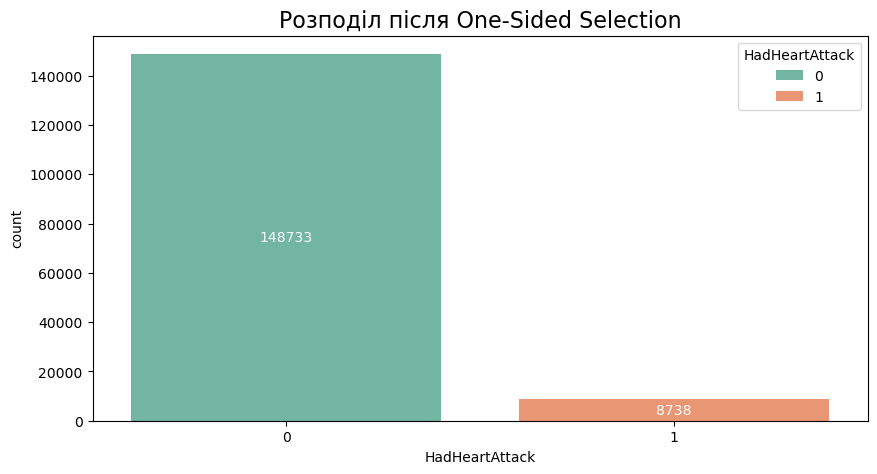

In [137]:
from imblearn.under_sampling import OneSidedSelection

oss = OneSidedSelection()
X_OSS, y_OSS = oss.fit_resample(X_initial_train, y_initial_train)

show_stats(y_OSS, "One Sided Selection")

In [138]:
train_models(X_OSS, y_OSS, "One_Sided_Selection")

           Logistic Regression
Accuracy              0.941468
Precision             0.469440
Recall                0.416667
F1-score              0.441482
AUC                   0.885670
           Decision Tree
Accuracy        0.913417
Precision       0.266630
Recall          0.319608
F1-score        0.290725
AUC             0.633966


Comparison After Validation

Logistic Regression
                           Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling           0.942793   0.470887  0.394294  0.429200  0.885052
Random_Undersampling       0.794409   0.175855  0.751118  0.284987  0.855964
Tomek_Links                0.940342   0.450849  0.429636  0.439987  0.884401
Edited_Nearest_Neighbours  0.924467   0.368582  0.539493  0.437954  0.882395
One_Sided_Selection        0.941062   0.456108  0.418139  0.436299  0.884350

Decision Tree
                           Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling           0.913121   0.248464  0.292740  0

### Neighbourhood Cleaning Rule

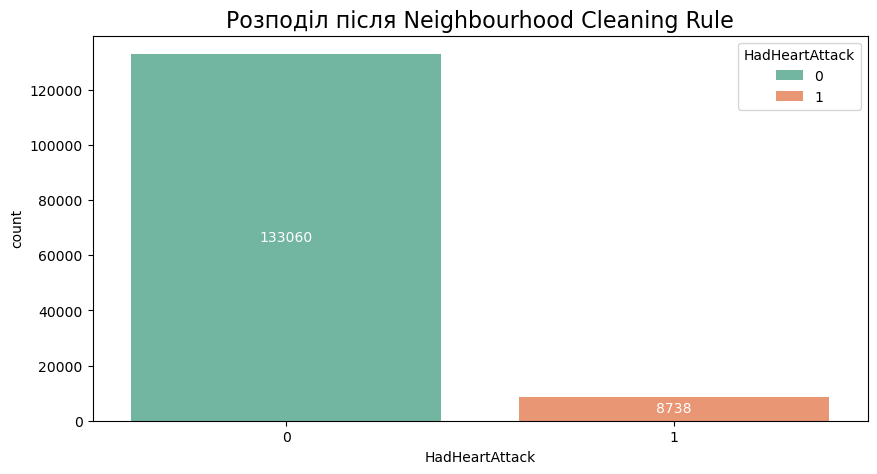

In [139]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

ncr = NeighbourhoodCleaningRule()
X_NCR, y_NCR = ncr.fit_resample(X_initial_train, y_initial_train)

show_stats(y_NCR, "Neighbourhood Cleaning Rule")

In [140]:
train_models(X_NCR, y_NCR, "Neighbourhood_Cleaning_Rule")

           Logistic Regression
Accuracy              0.933992
Precision             0.466828
Recall                0.506545
F1-score              0.485876
AUC                   0.894122
           Decision Tree
Accuracy        0.909269
Precision       0.298972
Recall          0.352094
F1-score        0.323366
AUC             0.648961


Comparison After Validation

Logistic Regression
                             Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling             0.942793   0.470887  0.394294  0.429200  0.885052
Random_Undersampling         0.794409   0.175855  0.751118  0.284987  0.855964
Tomek_Links                  0.940342   0.450849  0.429636  0.439987  0.884401
Edited_Nearest_Neighbours    0.924467   0.368582  0.539493  0.437954  0.882395
One_Sided_Selection          0.941062   0.456108  0.418139  0.436299  0.884350
Neighbourhood_Cleaning_Rule  0.928694   0.386467  0.522887  0.444444  0.882994

Decision Tree
                             Accuracy  Precis

### All KNN

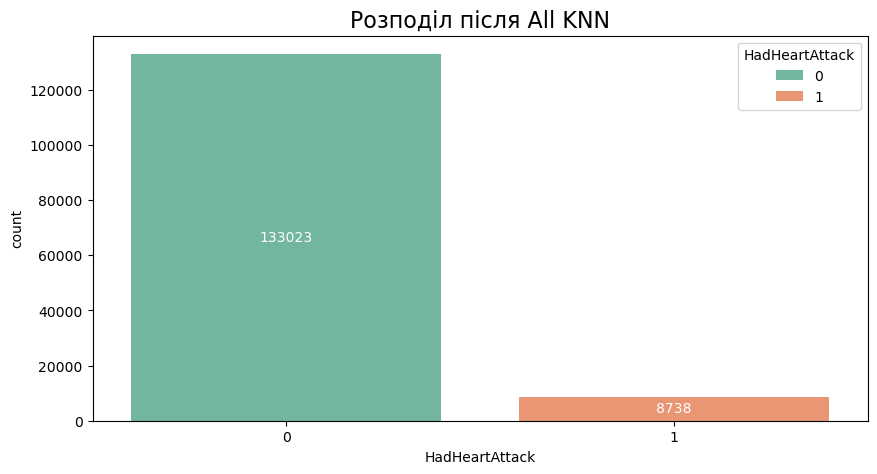

In [141]:
from imblearn.under_sampling import AllKNN

allknn = AllKNN()
X_AllKNN, y_AllKNN = allknn.fit_resample(X_initial_train, y_initial_train)

show_stats(y_AllKNN, "AllKNN")

In [142]:
train_models(X_AllKNN, y_AllKNN, "All_KNN")

           Logistic Regression
Accuracy              0.935607
Precision             0.485187
Recall                0.561994
F1-score              0.520774
AUC                   0.897324
           Decision Tree
Accuracy        0.913638
Precision       0.329727
Recall          0.374879
F1-score        0.350856
AUC             0.662143


Comparison After Validation

Logistic Regression
                             Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling             0.942793   0.470887  0.394294  0.429200  0.885052
Random_Undersampling         0.794409   0.175855  0.751118  0.284987  0.855964
Tomek_Links                  0.940342   0.450849  0.429636  0.439987  0.884401
Edited_Nearest_Neighbours    0.924467   0.368582  0.539493  0.437954  0.882395
One_Sided_Selection          0.941062   0.456108  0.418139  0.436299  0.884350
Neighbourhood_Cleaning_Rule  0.928694   0.386467  0.522887  0.444444  0.882994
All_KNN                      0.918521   0.348491  0.567809  

### NearMiss

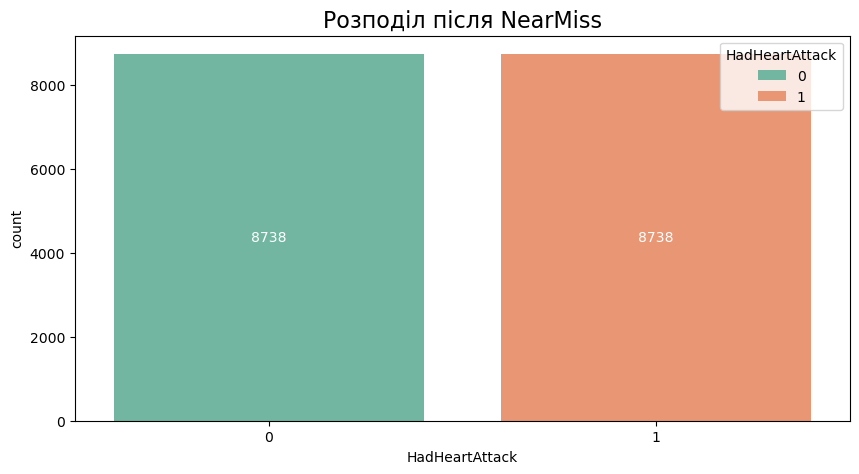

In [143]:
from imblearn.under_sampling import NearMiss

nearmiss = NearMiss()
X_NearMiss, y_NearMiss = nearmiss.fit_resample(X_initial_train, y_initial_train)

show_stats(y_NearMiss, "NearMiss")

In [144]:
train_models(X_NearMiss, y_NearMiss, "Near_Miss")

           Logistic Regression
Accuracy              0.848619
Precision             0.965472
Recall                0.722840
F1-score              0.826722
AUC                   0.934910
           Decision Tree
Accuracy        0.862514
Precision       0.860397
Recall          0.865183
F1-score        0.862783
AUC             0.862516


Comparison After Validation

Logistic Regression
                             Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling             0.942793   0.470887  0.394294  0.429200  0.885052
Random_Undersampling         0.794409   0.175855  0.751118  0.284987  0.855964
Tomek_Links                  0.940342   0.450849  0.429636  0.439987  0.884401
Edited_Nearest_Neighbours    0.924467   0.368582  0.539493  0.437954  0.882395
One_Sided_Selection          0.941062   0.456108  0.418139  0.436299  0.884350
Neighbourhood_Cleaning_Rule  0.928694   0.386467  0.522887  0.444444  0.882994
All_KNN                      0.918521   0.348491  0.567809  

### Cluster Centroids

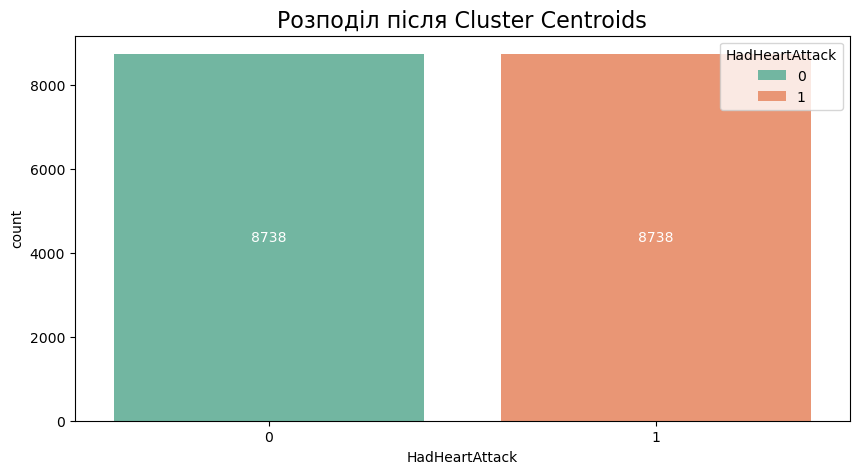

In [145]:
from imblearn.under_sampling import ClusterCentroids
from sklearn.cluster import KMeans

cc = ClusterCentroids(estimator=KMeans(n_clusters=10, random_state=42))
X_ClusterCentroids, y_ClusterCentroids = cc.fit_resample(X_initial_train, y_initial_train)

show_stats(y_ClusterCentroids, "Cluster Centroids")

In [146]:
train_models(X_ClusterCentroids, y_ClusterCentroids, "Cluster_Centroids")

           Logistic Regression
Accuracy              0.948177
Precision             0.958794
Recall                0.936518
F1-score              0.947525
AUC                   0.983101
           Decision Tree
Accuracy        0.962563
Precision       0.962079
Recall          0.963024
F1-score        0.962551
AUC             0.962564


Comparison After Validation

Logistic Regression
                             Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling             0.942793   0.470887  0.394294  0.429200  0.885052
Random_Undersampling         0.794409   0.175855  0.751118  0.284987  0.855964
Tomek_Links                  0.940342   0.450849  0.429636  0.439987  0.884401
Edited_Nearest_Neighbours    0.924467   0.368582  0.539493  0.437954  0.882395
One_Sided_Selection          0.941062   0.456108  0.418139  0.436299  0.884350
Neighbourhood_Cleaning_Rule  0.928694   0.386467  0.522887  0.444444  0.882994
All_KNN                      0.918521   0.348491  0.567809  

### Instance Hardness Threshold

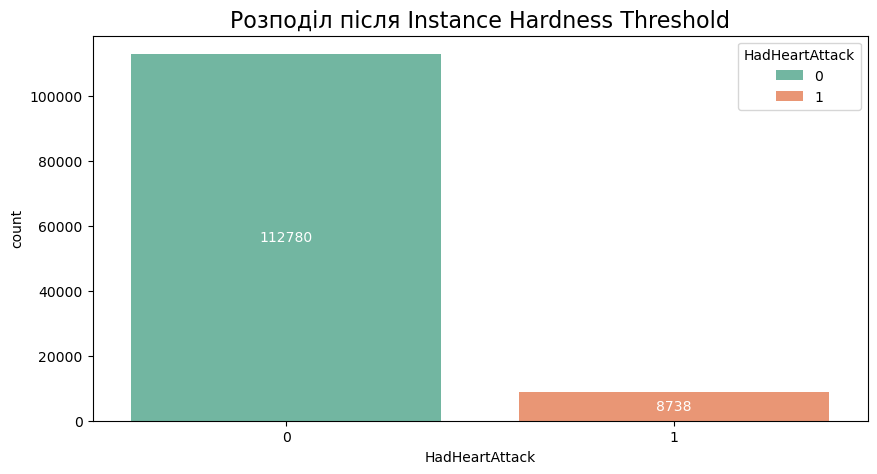

In [147]:
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.ensemble import RandomForestClassifier

iht = InstanceHardnessThreshold(estimator=RandomForestClassifier(n_estimators=10, random_state=42))
X_IHT, y_IHT = iht.fit_resample(X_initial_train, y_initial_train)

show_stats(y_IHT, "Instance Hardness Threshold")

In [148]:
train_models(X_IHT, y_IHT, "Instance_Hardness_Threshold")

           Logistic Regression
Accuracy              0.939834
Precision             0.565841
Recall                0.708225
F1-score              0.629077
AUC                   0.935269
           Decision Tree
Accuracy        0.939739
Precision       0.575248
Recall          0.625000
F1-score        0.599093
AUC             0.794587


Comparison After Validation

Logistic Regression
                             Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling             0.942793   0.470887  0.394294  0.429200  0.885052
Random_Undersampling         0.794409   0.175855  0.751118  0.284987  0.855964
Tomek_Links                  0.940342   0.450849  0.429636  0.439987  0.884401
Edited_Nearest_Neighbours    0.924467   0.368582  0.539493  0.437954  0.882395
One_Sided_Selection          0.941062   0.456108  0.418139  0.436299  0.884350
Neighbourhood_Cleaning_Rule  0.928694   0.386467  0.522887  0.444444  0.882994
All_KNN                      0.918521   0.348491  0.567809  

### Висновки

Виходячи з даних результатів я можу зробити 2 головних висновки:
1. Як і для підходу oversampling, дерева рішень працюють гірше за логістичну регресію в даному випадку. До того ж лише Instance Hardness Threshold зміг значно підвищити загальну точність моделі, припускаю причина цього в тому, що це єдиний метод балансування з використаних, що враховує складність усієї структури даних, а не лише найближчих сусідів.
2. Жоден метод undersampling балансування не зміг значно підвищити загальної точності логістичної регресії. Кожна модель має низький Precision (0.2-0.45), тобто близько поливина чи більше передбачень серцевих нападів будуть неправдивими для усіх підходів. Хоча деякі моделі добре передбачують реальні випадки серцевих нападів (Recall > 0.7), але роблять це за рахунок дуже великої кількості передбачень, більшість з яких все ж таки неправдиві (через що маємо стабільно низький Precision).

У випадку з методами "зрівняння" кількості позитивних та негативних випадків, як ось Random Undersampling, NearMiss та Cluster Centroids, отримуємо малу вибірку, всього близько 20 тис. записів суммарно. Також ми таким чином видаляємо дуже багато потенційно важливої інформації. (Важливість якої складно оцінити через велику кількіст параметрів у даних, близько 40 штук)

У випадку з методами зменшення шумів, я думаю, ми не отримуємо приросту точності через те, що дані попередньо очищені.

**В результаті жоден з undersampling методів балансування класів не запропонував збільшення точності моделі**.

In [149]:
with pd.ExcelWriter('undersampling_comparison.xlsx') as writer:
    all_logreg_logs.transpose().to_excel(writer, sheet_name='LogisticRegression', index=False)
    all_dtree_logs.transpose().to_excel(writer, sheet_name='DecisionTree', index=False)

print("Excel файл успішно створено")

Excel файл успішно створено
